In [4]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import DataLoader, random_split
from tqdm import tqdm
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# Check and set the device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda')

In [5]:
# Federated learning hyperparameters
num_epochs, learning_rate = 5, 0.001
batch_sizes, communication_rounds = [64, 128], 100
overlap_percentage = 25 # Dmeta hyperparameter

In [6]:
# Define a deep learning model (CNN)
class CNNModel(nn.Module):
    def __init__(self):
        super(CNNModel, self).__init__()
        # Modify the architecture based on your requirements
        self.conv1 = nn.Conv2d(1, 32, kernel_size=3, padding=1)
        self.relu1 = nn.ReLU()
        self.maxpool1 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        self.relu2 = nn.ReLU()
        self.maxpool2 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.fc1 = nn.Linear(64 * 7 * 7, 512)
        self.relu3 = nn.ReLU()
        self.fc2 = nn.Linear(512, 10)  # Assuming 10 classes

    def forward(self, x):
        x = self.conv1(x)
        x = self.relu1(x)
        x = self.maxpool1(x)
        x = self.conv2(x)
        x = self.relu2(x)
        x = self.maxpool2(x)
        x = x.view(x.size(0), -1)
        x = self.fc1(x)
        x = self.relu3(x)
        x = self.fc2(x)
        return x

In [7]:
# Dataset preparation
transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.5,), (0.5,))])

# Assuming you have the FEMNIST dataset downloaded and split for each client
# Replace 'path_to_client_data' with the actual path to the client data
client_dataset = torchvision.datasets.FashionMNIST(root='path_to_client_data', train=True, download=True, transform=transform)

# Split the client dataset into train and validation sets
train_size = int(0.8 * len(client_dataset))
val_size = len(client_dataset) - train_size
client_train_set, client_val_set = random_split(client_dataset, [train_size, val_size])

# DataLoader for training and validation
train_loaders = [DataLoader(client_train_set, batch_size=batch_size, shuffle=True, num_workers=4) for batch_size in batch_sizes]
val_loader = DataLoader(client_val_set, batch_size=batch_sizes[0], shuffle=False, num_workers=4)

100%|██████████| 26421880/26421880 [00:02<00:00, 9923516.55it/s] 


Extracting path_to_client_data/FashionMNIST/raw/train-images-idx3-ubyte.gz to path_to_client_data/FashionMNIST/raw



100%|██████████| 29515/29515 [00:00<00:00, 167024.05it/s]


Extracting path_to_client_data/FashionMNIST/raw/train-labels-idx1-ubyte.gz to path_to_client_data/FashionMNIST/raw



100%|██████████| 4422102/4422102 [00:01<00:00, 3100686.00it/s]


Extracting path_to_client_data/FashionMNIST/raw/t10k-images-idx3-ubyte.gz to path_to_client_data/FashionMNIST/raw



100%|██████████| 5148/5148 [00:00<00:00, 5977928.29it/s]

Extracting path_to_client_data/FashionMNIST/raw/t10k-labels-idx1-ubyte.gz to path_to_client_data/FashionMNIST/raw




/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


In [23]:
# Function to train the model for a given federated learning algorithm
def train_federated_learning_with_dmeta(model, train_loader, dmeta_loader, algorithm_name):
    model.train()
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=learning_rate)

    performance_metrics = {'accuracy': [], 'loss': []}

    for epoch in range(num_epochs):
        running_loss = 0.0

        # Train on D
        for images, labels in tqdm(train_loader, desc=f'Epoch {epoch + 1}/{num_epochs} - {algorithm_name} - D'):
            images, labels = images.to(device), labels.to(device)

            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            running_loss += loss.item()

        # Train on Dmeta
        for images, labels in tqdm(dmeta_loader, desc=f'Epoch {epoch + 1}/{num_epochs} - {algorithm_name} - Dmeta'):
            images, labels = images.to(device), labels.to(device)

            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            running_loss += loss.item()

        # Print average loss at the end of each epoch
        average_loss = running_loss / (len(train_loader) + len(dmeta_loader))
        print(f'Epoch [{epoch + 1}/{num_epochs}] - {algorithm_name}, Loss: {average_loss:.4f}')

        # Evaluate on validation set
        accuracy = evaluate_model(model, val_loader)
        print(f'Epoch [{epoch + 1}/{num_epochs}] - {algorithm_name}, Validation Accuracy: {accuracy * 100:.2f}%')

        performance_metrics['accuracy'].append(accuracy)
        performance_metrics['loss'].append(average_loss)

    return performance_metrics

def train_federated_learning(model, train_loader, algorithm_name):
    model.train()
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=learning_rate)

    performance_metrics = {'accuracy': [], 'loss': []}

    for epoch in range(num_epochs):
        running_loss = 0.0
        for images, labels in tqdm(train_loader, desc=f'Epoch {epoch + 1}/{num_epochs} - {algorithm_name}'):
            images, labels = images.to(device), labels.to(device)

            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            running_loss += loss.item()

        # Print average loss at the end of each epoch
        average_loss = running_loss / len(train_loader)
        print(f'Epoch [{epoch + 1}/{num_epochs}] - {algorithm_name}, Loss: {average_loss:.4f}')

        # Evaluate on validation set
        accuracy = evaluate_model(model, val_loader)
        print(f'Epoch [{epoch + 1}/{num_epochs}] - {algorithm_name}, Validation Accuracy: {accuracy * 100:.2f}%')

        performance_metrics['accuracy'].append(accuracy)
        performance_metrics['loss'].append(average_loss)

    return performance_metrics

# Function to evaluate the model on the validation set
def evaluate_model(model, val_loader):
    model.eval()
    correct, total = 0, 0
    with torch.no_grad():
        for images, labels in val_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    accuracy = correct / total
    return accuracy

In [24]:
# Train & Evaluate FedAvg
fedavg_model = CNNModel().to(device)
fedavg_performance = train_federated_learning(fedavg_model, train_loaders[0], 'FedAvg')

# Train & Evaluate FedProx
fedprox_model = CNNModel().to(device)
fedprox_performance = train_federated_learning(fedprox_model, train_loaders[0], 'FedProx')

# Train & Evaluate FedShare
fedshare_model = CNNModel().to(device)
fedshare_performance = train_federated_learning(fedshare_model, train_loaders[0], 'FedShare')

# Train & Evaluate FedMeta w/ UGA
fedmeta_uga_model = CNNModel().to(device)
fedmeta_uga_performance = train_federated_learning(fedmeta_uga_model, train_loaders[0], 'FedMeta w/ UGA')

Epoch 1/5 - FedAvg: 100%|██████████| 750/750 [00:14<00:00, 50.98it/s]


Epoch [1/5] - FedAvg, Loss: 0.4248
Epoch [1/5] - FedAvg, Validation Accuracy: 88.83%


Epoch 2/5 - FedAvg: 100%|██████████| 750/750 [00:17<00:00, 43.53it/s]

Epoch [2/5] - FedAvg, Loss: 0.2702


Epoch [2/5] - FedAvg, Validation Accuracy: 90.47%


Epoch 3/5 - FedAvg: 100%|██████████| 750/750 [00:16<00:00, 45.50it/s]

Epoch [3/5] - FedAvg, Loss: 0.2183


Epoch [3/5] - FedAvg, Validation Accuracy: 91.43%


Epoch 4/5 - FedAvg: 100%|██████████| 750/750 [00:17<00:00, 44.09it/s]

Epoch [4/5] - FedAvg, Loss: 0.1809


Epoch [4/5] - FedAvg, Validation Accuracy: 91.84%


Epoch 5/5 - FedAvg: 100%|██████████| 750/750 [00:13<00:00, 54.67it/s]

Epoch [5/5] - FedAvg, Loss: 0.1510


Epoch [5/5] - FedAvg, Validation Accuracy: 91.99%


Epoch 1/5 - FedProx: 100%|██████████| 750/750 [00:15<00:00, 49.02it/s]

Epoch [1/5] - FedProx, Loss: 0.4260


Epoch [1/5] - FedProx, Validation Accuracy: 88.70%


Epoch 2/5 - FedProx: 100%|██████████| 750/750 [00:15<00:00, 48.71it/s]

Epoch [2/5] - FedProx, Loss: 0.2730


Epoch [2/5] - FedProx, Validation Accuracy: 90.77%


Epoch 3/5 - FedProx: 100%|██████████| 750/750 [00:14<00:00, 51.64it/s]

Epoch [3/5] - FedProx, Loss: 0.2232


Epoch [3/5] - FedProx, Validation Accuracy: 90.69%


Epoch 4/5 - FedProx: 100%|██████████| 750/750 [00:13<00:00, 56.11it/s]

Epoch [4/5] - FedProx, Loss: 0.1869


Epoch [4/5] - FedProx, Validation Accuracy: 91.84%


Epoch 5/5 - FedProx: 100%|██████████| 750/750 [00:13<00:00, 55.40it/s]

Epoch [5/5] - FedProx, Loss: 0.1534


Epoch [5/5] - FedProx, Validation Accuracy: 91.83%


Epoch 1/5 - FedShare: 100%|██████████| 750/750 [00:13<00:00, 55.98it/s]

Epoch [1/5] - FedShare, Loss: 0.4258


Epoch [1/5] - FedShare, Validation Accuracy: 88.70%


Epoch 2/5 - FedShare: 100%|██████████| 750/750 [00:13<00:00, 56.16it/s]

Epoch [2/5] - FedShare, Loss: 0.2702


Epoch [2/5] - FedShare, Validation Accuracy: 90.40%


Epoch 3/5 - FedShare: 100%|██████████| 750/750 [00:13<00:00, 53.97it/s]

Epoch [3/5] - FedShare, Loss: 0.2204


Epoch [3/5] - FedShare, Validation Accuracy: 91.44%


Epoch 4/5 - FedShare: 100%|██████████| 750/750 [00:14<00:00, 53.08it/s]

Epoch [4/5] - FedShare, Loss: 0.1851


Epoch [4/5] - FedShare, Validation Accuracy: 91.97%


Epoch 5/5 - FedShare: 100%|██████████| 750/750 [00:13<00:00, 54.70it/s]

Epoch [5/5] - FedShare, Loss: 0.1517


Epoch [5/5] - FedShare, Validation Accuracy: 92.07%


Epoch 1/5 - FedMeta w/ UGA: 100%|██████████| 750/750 [00:13<00:00, 55.52it/s]

Epoch [1/5] - FedMeta w/ UGA, Loss: 0.4323


Epoch [1/5] - FedMeta w/ UGA, Validation Accuracy: 88.02%


Epoch 2/5 - FedMeta w/ UGA: 100%|██████████| 750/750 [00:13<00:00, 56.66it/s]

Epoch [2/5] - FedMeta w/ UGA, Loss: 0.2750


Epoch [2/5] - FedMeta w/ UGA, Validation Accuracy: 89.75%


Epoch 3/5 - FedMeta w/ UGA: 100%|██████████| 750/750 [00:13<00:00, 55.80it/s]

Epoch [3/5] - FedMeta w/ UGA, Loss: 0.2236


Epoch [3/5] - FedMeta w/ UGA, Validation Accuracy: 91.30%


Epoch 4/5 - FedMeta w/ UGA: 100%|██████████| 750/750 [00:13<00:00, 55.76it/s]

Epoch [4/5] - FedMeta w/ UGA, Loss: 0.1881


Epoch [4/5] - FedMeta w/ UGA, Validation Accuracy: 91.68%


Epoch 5/5 - FedMeta w/ UGA: 100%|██████████| 750/750 [00:15<00:00, 47.90it/s]

Epoch [5/5] - FedMeta w/ UGA, Loss: 0.1543


Epoch [5/5] - FedMeta w/ UGA, Validation Accuracy: 91.87%


In [25]:
# Number of writers in Dmeta
num_writers_dmeta = int(overlap_percentage / 100 * len(client_dataset))

# Select writers from D and the auxiliary dataset
writers_d = client_dataset.targets.unique().tolist()
writers_auxiliary = list(range(100))  # Assuming 100 writers in the auxiliary dataset

# Select a certain proportion of writers from D and the rest from the auxiliary dataset
selected_writers_d = writers_d[:len(writers_d) - num_writers_dmeta]
selected_writers_auxiliary = writers_auxiliary[:num_writers_dmeta]

# Combine selected writers to form Dmeta writers
writers_dmeta = selected_writers_d + selected_writers_auxiliary

# Sample 1% examples to form Dmeta
num_samples_dmeta = int(0.01 * len(client_dataset))
indices_dmeta = torch.randperm(len(client_dataset))[:num_samples_dmeta]

# Create Dmeta by selecting examples from D and auxiliary dataset
data_dmeta = [client_dataset[i] for i in indices_dmeta]
dmeta_loader = DataLoader(data_dmeta, batch_size=batch_sizes[0], shuffle=True, num_workers=4)

In [26]:
# Train & Evaluate FedAvg
fedavg_performance_dmeta = train_federated_learning_with_dmeta(fedavg_model, train_loaders[0], dmeta_loader, 'FedAvg with Dmeta')

# Train & Evaluate FedProx
fedprox_performance_dmeta = train_federated_learning_with_dmeta(fedprox_model, train_loaders[0], dmeta_loader, 'FedProx with Dmeta')

# Train & Evaluate FedShare
fedshare_performance_dmeta = train_federated_learning_with_dmeta(fedshare_model, train_loaders[0], dmeta_loader, 'FedShare with Dmeta')

# Train & Evaluate FedMeta w/ UGA
fedmeta_uga_performance_dmeta = train_federated_learning_with_dmeta(fedmeta_uga_model, train_loaders[0], dmeta_loader, 'FedMeta w/ UGA with Dmeta')

Epoch 1/5 - FedAvg with Dmeta - Dmeta: 100%|██████████| 10/10 [00:00<00:00, 46.02it/s]

Epoch [1/5] - FedAvg with Dmeta, Loss: 0.1251


Epoch [1/5] - FedAvg with Dmeta, Validation Accuracy: 91.75%


Epoch 2/5 - FedAvg with Dmeta - Dmeta: 100%|██████████| 10/10 [00:00<00:00, 47.16it/s]

Epoch [2/5] - FedAvg with Dmeta, Loss: 0.0975


Epoch [2/5] - FedAvg with Dmeta, Validation Accuracy: 92.51%


Epoch 3/5 - FedAvg with Dmeta - Dmeta: 100%|██████████| 10/10 [00:00<00:00, 47.99it/s]

Epoch [3/5] - FedAvg with Dmeta, Loss: 0.0747


Epoch [3/5] - FedAvg with Dmeta, Validation Accuracy: 91.77%


Epoch 4/5 - FedAvg with Dmeta - Dmeta: 100%|██████████| 10/10 [00:00<00:00, 46.93it/s]

Epoch [4/5] - FedAvg with Dmeta, Loss: 0.0577


Epoch [4/5] - FedAvg with Dmeta, Validation Accuracy: 92.12%


Epoch 5/5 - FedAvg with Dmeta - Dmeta: 100%|██████████| 10/10 [00:00<00:00, 31.63it/s]

Epoch [5/5] - FedAvg with Dmeta, Loss: 0.0446


Epoch [5/5] - FedAvg with Dmeta, Validation Accuracy: 92.47%


Epoch 1/5 - FedProx with Dmeta - Dmeta: 100%|██████████| 10/10 [00:00<00:00, 41.36it/s]

Epoch [1/5] - FedProx with Dmeta, Loss: 0.1294


Epoch [1/5] - FedProx with Dmeta, Validation Accuracy: 91.92%


Epoch 2/5 - FedProx with Dmeta - Dmeta: 100%|██████████| 10/10 [00:00<00:00, 43.50it/s]

Epoch [2/5] - FedProx with Dmeta, Loss: 0.0989


Epoch [2/5] - FedProx with Dmeta, Validation Accuracy: 91.66%


Epoch 3/5 - FedProx with Dmeta - Dmeta: 100%|██████████| 10/10 [00:00<00:00, 41.85it/s]

Epoch [3/5] - FedProx with Dmeta, Loss: 0.0792


Epoch [3/5] - FedProx with Dmeta, Validation Accuracy: 92.10%


Epoch 4/5 - FedProx with Dmeta - Dmeta: 100%|██████████| 10/10 [00:00<00:00, 45.29it/s]

Epoch [4/5] - FedProx with Dmeta, Loss: 0.0612


Epoch [4/5] - FedProx with Dmeta, Validation Accuracy: 91.67%


Epoch 5/5 - FedProx with Dmeta - Dmeta: 100%|██████████| 10/10 [00:00<00:00, 28.82it/s]

Epoch [5/5] - FedProx with Dmeta, Loss: 0.0479


Epoch [5/5] - FedProx with Dmeta, Validation Accuracy: 91.85%


Epoch 1/5 - FedShare with Dmeta - Dmeta: 100%|██████████| 10/10 [00:00<00:00, 47.49it/s]

Epoch [1/5] - FedShare with Dmeta, Loss: 0.1296


Epoch [1/5] - FedShare with Dmeta, Validation Accuracy: 91.80%


Epoch 2/5 - FedShare with Dmeta - Dmeta: 100%|██████████| 10/10 [00:00<00:00, 46.31it/s]

Epoch [2/5] - FedShare with Dmeta, Loss: 0.0990


Epoch [2/5] - FedShare with Dmeta, Validation Accuracy: 91.72%


Epoch 3/5 - FedShare with Dmeta - Dmeta: 100%|██████████| 10/10 [00:00<00:00, 43.81it/s]

Epoch [3/5] - FedShare with Dmeta, Loss: 0.0762


Epoch [3/5] - FedShare with Dmeta, Validation Accuracy: 91.89%


Epoch 4/5 - FedShare with Dmeta - Dmeta: 100%|██████████| 10/10 [00:00<00:00, 43.20it/s]

Epoch [4/5] - FedShare with Dmeta, Loss: 0.0603


Epoch [4/5] - FedShare with Dmeta, Validation Accuracy: 91.78%


Epoch 5/5 - FedShare with Dmeta - Dmeta: 100%|██████████| 10/10 [00:00<00:00, 42.93it/s]

Epoch [5/5] - FedShare with Dmeta, Loss: 0.0473


Epoch [5/5] - FedShare with Dmeta, Validation Accuracy: 91.76%


Epoch 1/5 - FedMeta w/ UGA with Dmeta - Dmeta: 100%|██████████| 10/10 [00:00<00:00, 29.20it/s]

Epoch [1/5] - FedMeta w/ UGA with Dmeta, Loss: 0.1320


Epoch [1/5] - FedMeta w/ UGA with Dmeta, Validation Accuracy: 91.66%


Epoch 2/5 - FedMeta w/ UGA with Dmeta - Dmeta: 100%|██████████| 10/10 [00:00<00:00, 46.18it/s]

Epoch [2/5] - FedMeta w/ UGA with Dmeta, Loss: 0.1021


Epoch [2/5] - FedMeta w/ UGA with Dmeta, Validation Accuracy: 92.34%


Epoch 3/5 - FedMeta w/ UGA with Dmeta - Dmeta: 100%|██████████| 10/10 [00:00<00:00, 44.90it/s]

Epoch [3/5] - FedMeta w/ UGA with Dmeta, Loss: 0.0794


Epoch [3/5] - FedMeta w/ UGA with Dmeta, Validation Accuracy: 91.39%


Epoch 4/5 - FedMeta w/ UGA with Dmeta - Dmeta: 100%|██████████| 10/10 [00:00<00:00, 45.39it/s]

Epoch [4/5] - FedMeta w/ UGA with Dmeta, Loss: 0.0639


Epoch [4/5] - FedMeta w/ UGA with Dmeta, Validation Accuracy: 91.90%


Epoch 5/5 - FedMeta w/ UGA with Dmeta - Dmeta: 100%|██████████| 10/10 [00:00<00:00, 45.58it/s]

Epoch [5/5] - FedMeta w/ UGA with Dmeta, Loss: 0.0490


Epoch [5/5] - FedMeta w/ UGA with Dmeta, Validation Accuracy: 92.06%


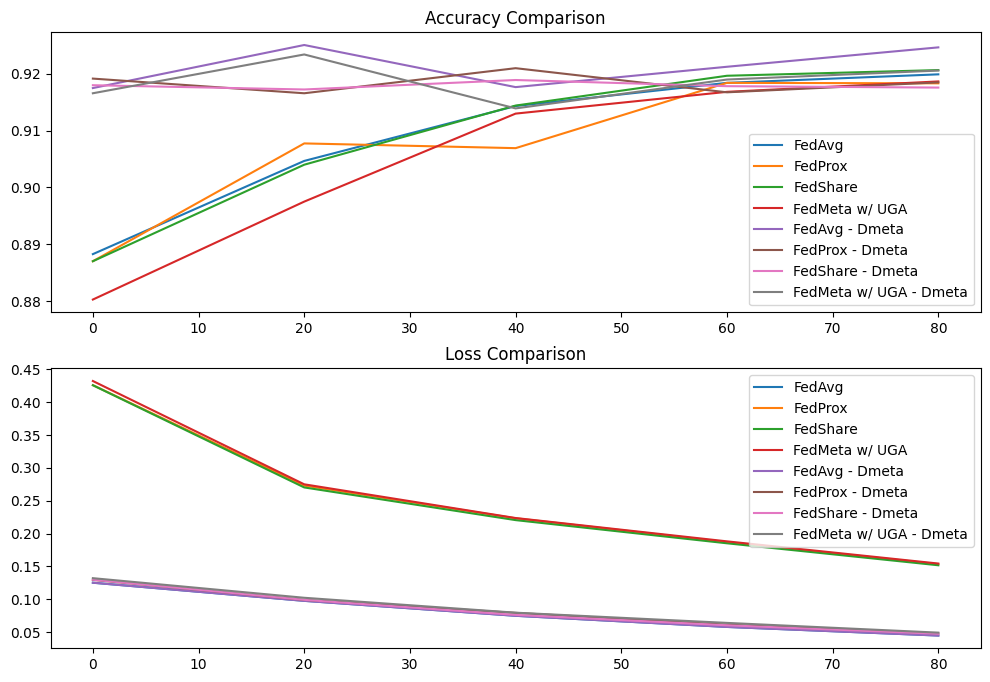

In [27]:
# Create comparison plots for FEMNIST
plt.figure(figsize=(12, 8))

# Test accuracy comparison
plt.subplot(2, 1, 1)
plt.title("Accuracy Comparison")
sns.lineplot(x=range(0, communication_rounds, 20), y=fedavg_performance['accuracy'], label='FedAvg')
sns.lineplot(x=range(0, communication_rounds, 20), y=fedprox_performance['accuracy'], label='FedProx')
sns.lineplot(x=range(0, communication_rounds, 20), y=fedshare_performance['accuracy'], label='FedShare')
sns.lineplot(x=range(0, communication_rounds, 20), y=fedmeta_uga_performance['accuracy'], label='FedMeta w/ UGA')

sns.lineplot(x=range(0, communication_rounds, 20), y=fedavg_performance_dmeta['accuracy'], label='FedAvg - Dmeta')
sns.lineplot(x=range(0, communication_rounds, 20), y=fedprox_performance_dmeta['accuracy'], label='FedProx - Dmeta')
sns.lineplot(x=range(0, communication_rounds, 20), y=fedshare_performance_dmeta['accuracy'], label='FedShare - Dmeta')
sns.lineplot(x=range(0, communication_rounds, 20), y=fedmeta_uga_performance_dmeta['accuracy'], label='FedMeta w/ UGA - Dmeta')

# Loss comparison
plt.subplot(2, 1, 2)
plt.title("Loss Comparison")
sns.lineplot(x=range(0, communication_rounds, 20), y=fedavg_performance_dmeta['loss'], label='FedAvg')
sns.lineplot(x=range(0, communication_rounds, 20), y=fedprox_performance['loss'], label='FedProx')
sns.lineplot(x=range(0, communication_rounds, 20), y=fedshare_performance['loss'], label='FedShare')
sns.lineplot(x=range(0, communication_rounds, 20), y=fedmeta_uga_performance['loss'], label='FedMeta w/ UGA')

sns.lineplot(x=range(0, communication_rounds, 20), y=fedavg_performance_dmeta['loss'], label='FedAvg - Dmeta')
sns.lineplot(x=range(0, communication_rounds, 20), y=fedprox_performance_dmeta['loss'], label='FedProx - Dmeta')
sns.lineplot(x=range(0, communication_rounds, 20), y=fedshare_performance_dmeta['loss'], label='FedShare - Dmeta')
sns.lineplot(x=range(0, communication_rounds, 20), y=fedmeta_uga_performance_dmeta['loss'], label='FedMeta w/ UGA - Dmeta')

plt.show()